#尝试只使用能量函数进行变形约束

In [8]:
# -*- coding: utf-8 -*-
__author__ = 'Zhe'
%pylab inline
import theano
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import io
import skimage
from theano.tensor.nnet import conv #接触theano进行卷积操作
import time
from pylab import mpl
from skimage import data
import math
'''
输入两个patch，返回变形的（u,v）向量
'''
#解决matlibplot当中中文显示问题
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#变形patch类

In [63]:
#修改成不等大小patch
import theano
import theano.tensor as T
from theano.tensor.nnet import conv #接触theano进行卷积操作
#这里并非优化W而是优化(u,v)
class deformed_patch(object):
    def __init__(self):
        pass
    #输入两块相同大小并且有略微变形的patch，计算变形程度(U,V)
    def getUV(self,img_in,img_out):
        #print( img_in.dtype,img_in.shape)

        xlen = img_in.shape[1]
        ylen = img_in.shape[0]

        img_out# = img_out.reshape((1, 1, ylen, xlen))
        img_in #= img_in.reshape((1, 1, ylen, xlen))

        src_in = T.dmatrix()
        dst_in = T.dmatrix()
        #正则化，使均值变为0
        src_in = src_in - T.sum(src_in)/(xlen*ylen)
        dst_in = dst_in - T.sum(dst_in)/(xlen*ylen)

        src = src_in.reshape((1, 1, ylen, xlen))
        dst = dst_in.reshape((1, 1, ylen, xlen))

        #声明两个方向平移域
        u = theano.shared(
                value=np.zeros([1, 1, ylen, xlen],dtype=theano.config.floatX),
                borrow=True
            )
        v = theano.shared(
                value=np.zeros([1, 1, ylen, xlen],dtype=theano.config.floatX),
                borrow=True
            )
        #print u"声明结束"

        filter_shape = np.asarray([2,1,2,2],dtype='int')
        image_shape = np.asarray([1,1,ylen,xlen],dtype='int') #就是实际图像的大小

        #计算两个方向的梯度
        Wx=np.asarray([[-1,1],[0,0]],dtype='float64') #结果是W+Wx
        Wy=np.asarray([[-1,0],[1,0]],dtype='float64') #
        W=np.zeros(filter_shape)
        W[0,0]=Wx
        W[1,0]=Wy
        #print W.shape
        #print filter_shape.shape
        #print image_shape.shape
        #首先需要计算梯度
        src_grad = conv.conv2d(
                input=src,
                filters=W,
                filter_shape=filter_shape,
                image_shape=image_shape,
                border_mode="full" #这个参数保证边界完整
            )#卷积会忽略边界

        print u"梯度计算结束"

        #--v*src_grad[1,2,:,:])**2
        ''' '''
        gu = conv.conv2d(
                input=src,
                filters=W,
                filter_shape=filter_shape,
                image_shape=image_shape
            )#卷积会忽略边界
        gv = conv.conv2d(
                input=src,
                filters=W,
                filter_shape=filter_shape,
                image_shape=image_shape
            )#卷积会忽略边界
        #代价函数
        cost = T.sum((dst - src+u*src_grad[0,1,0:ylen,0:xlen]+v*src_grad[0,0,0:ylen,0:xlen])**2)+0.1*T.mean(gv**2+gu**2)#+0.05*T.mean(v**2+u**2)
        params = [u,v]
        grads = T.grad(cost, params)#所有的梯度
        updates = [
            (param_i, param_i - 0.5 * grad_i)
            for param_i, grad_i in zip(params, grads)
        ]

        print u"create"
        train_model = theano.function(
            [src_in,dst_in],
            [cost,src_grad],
            updates=updates,
        )

        #theano.printing.pydotprint(train_model, outfile="tree.png", var_with_name_simple=True)
        print u"compute"
        g=[]
        a = time.time()

        for i in xrange(100):
            [c,g] = train_model(img_in,img_out)
            #print c
        b = time.time()
        #print b-a

        '''
        p = theano.function([src_in],src_grad)
        c = p(img_in)

        print c.dtype,c.shape
        '''
        img_in=img_in.reshape((1, 1, ylen, xlen))
        img_in=img_in[0,0,0:ylen,0:xlen]
        cp=img_in-u.get_value()*g[0,1,0:ylen,0:xlen]-v.get_value()*g[0,0,0:ylen,0:xlen]
        return (u.get_value(),v.get_value(),cp)

#提取一些patch进行计算

In [64]:
#显示patch，
def visualize_patches(B):
    # assume square
    mpatch = int(math.floor(math.sqrt(B.shape[0])))
    npatch = mpatch

    m = int(math.floor(math.sqrt(B.shape[1])))
    n = int(math.ceil(B.shape[1] * 1.0 / m))
    collage = np.zeros((m*mpatch, n*npatch))
    for i in xrange(m):
        for j in xrange(n):
            try:
                patch = B[:, i*n + j]
            except IndexError:
                continue
            patch = onto_unit(patch.reshape((mpatch, npatch)))
            collage[i*mpatch:(i+1)*mpatch, j*npatch:(j+1)*npatch] = patch
    plt.imshow(collage, cmap=cm.gray, interpolation="none")
def onto_unit(x):
    a = np.min(x)
    b = np.max(x)
    return (x - a) / (b - a)

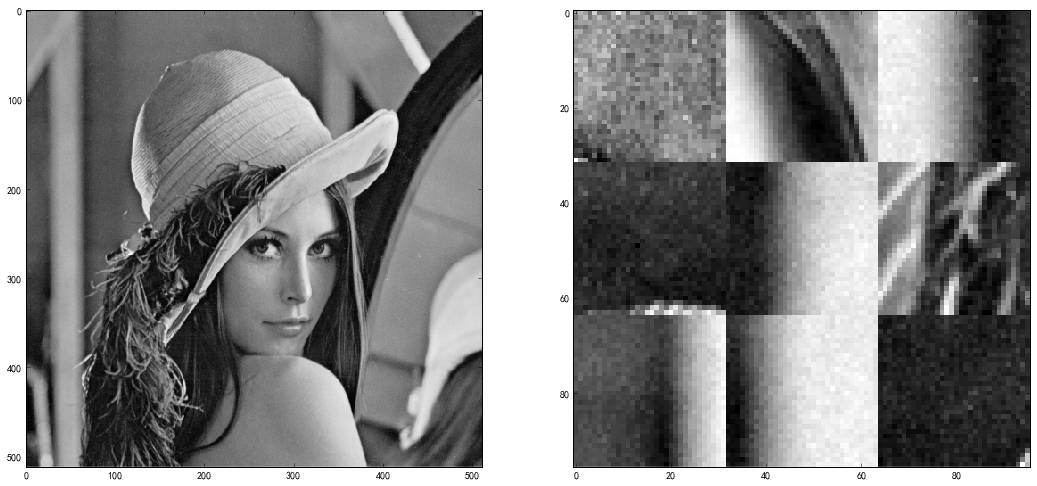

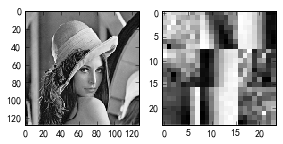

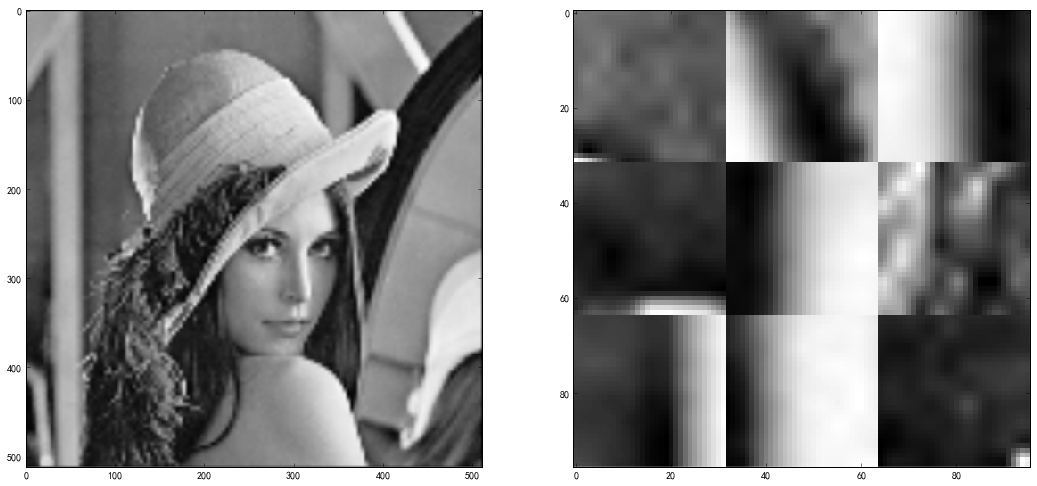

In [65]:
import random
from skimage.transform import rescale
#imageH = skimage.restoration.denoise_tv_chambolle(imageH)
imageH = skimage.color.rgb2gray(data.lena())
imageW = rescale(imageH,0.25,preserve_range=False)
imageL = rescale(img,4.0,preserve_range=False)


patch_sizeH = 32 #获取patch的尺寸
patch_sizeW = 8 
num_patches = 9 #获取patch的数量
columnsH = []
columnsL = []
columnsW = []
for i in xrange(num_patches):
    #提取所需patch左上角坐标
    y,x = [random.randint(0,imageH.shape[d] - patch_sizeH) for d in (0,1)]
    yL,xL = y/4,x/4
    #提取所需patch并向量化
    column  = imageH[x:x+patch_sizeH,y:y+patch_sizeH].reshape((patch_sizeH**2,1))
    columnsH.append(column)
    column  = imageL[x:x+patch_sizeH,y:y+patch_sizeH].reshape((patch_sizeH**2,1))
    columnsL.append(column)
    column  = imageW[xL:xL+patch_sizeW,yL:yL+patch_sizeW].reshape((patch_sizeW**2,1))
    columnsW.append(column)
    
#将list对跌成矩阵
XH = np.hstack(columnsH)
XL = np.hstack(columnsL)
XW = np.hstack(columnsW)
#转换成numpy数组
XH = np.asarray(XH,dtype='float64')
XL = np.asarray(XL,dtype='float64')
XW = np.asarray(XW,dtype='float64')

plt.figure(figsize=(18,18),dpi=14)
plt.subplot(1,2,1)
plt.imshow(imageH, cmap=cm.gray, interpolation="none")
plt.subplot(1,2,2)
visualize_patches(XH)

plt.figure(figsize=(4.5,4.5),dpi=14)
plt.subplot(1,2,1)
plt.imshow(imageW, cmap=cm.gray, interpolation="none")
plt.subplot(1,2,2)
visualize_patches(XW)

plt.figure(figsize=(18,18),dpi=14)
plt.subplot(1,2,1)
plt.imshow(imageL, cmap=cm.gray, interpolation="none")
plt.subplot(1,2,2)
visualize_patches(XL)
plt.show()

梯度计算结束
create
compute


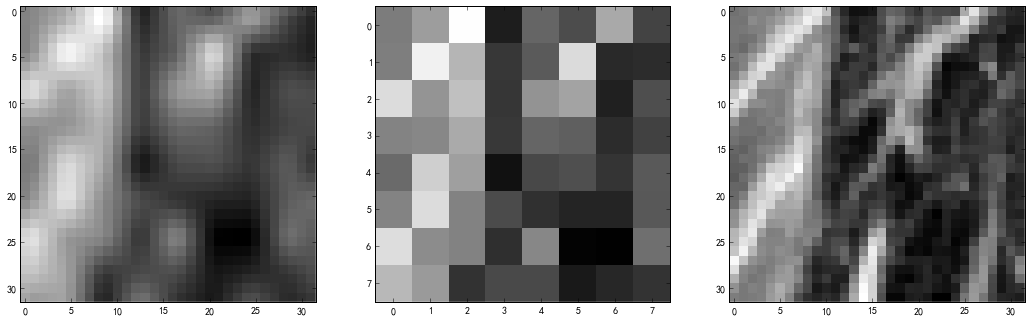

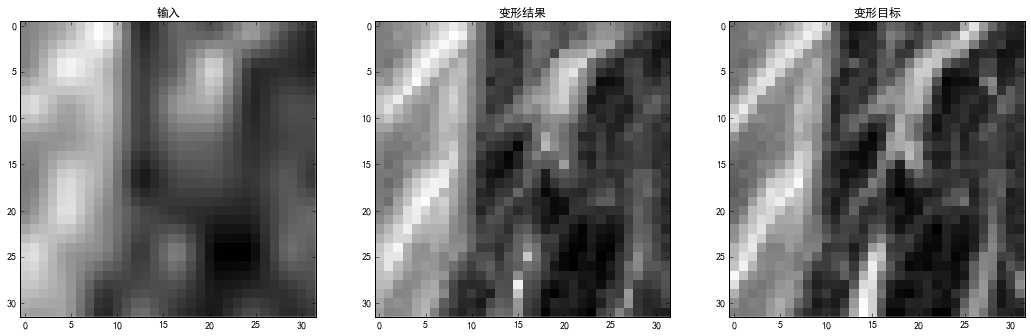

In [69]:
#对lena进行超分辨率处理
#XL是高分辨率
#XH是低分辨率
img_A = columnsL[5].reshape((32,32))
img_C = columnsW[5].reshape((8,8))
img_B = columnsH[5].reshape((32,32))
plt.figure(figsize=(18,18),dpi=19)
plt.subplot(1,3,1)
plt.imshow(img_A, cmap=cm.gray, interpolation="none")
plt.subplot(1,3,2)
plt.imshow(img_C, cmap=cm.gray, interpolation="none")
plt.subplot(1,3,3)
plt.imshow(img_B, cmap=cm.gray, interpolation="none")

dp = deformed_patch()
(u,v,cp) = dp.getUV(skimage.img_as_float(img_B),skimage.img_as_float(img_A))
plt.figure(figsize=(18,18),dpi=19)
u=u.reshape(u.shape[2],u.shape[3])
v=v.reshape(v.shape[2],v.shape[3])
cp=cp.reshape(cp.shape[2],cp.shape[3])

plt.subplot(1,3,1)
plt.title(u"输入")
plt.imshow(skimage.img_as_float(img_A),cmap=cm.gray, interpolation="none")
plt.subplot(1,3,2)
plt.title(u"变形结果")
plt.imshow(cp,cmap=cm.gray, interpolation="none")
plt.subplot(1,3,3)
plt.title(u"变形目标")
plt.imshow(skimage.img_as_float(img_B),cmap=cm.gray, interpolation="none")
plt.show()
cp = np.asarray(cp,dtype='float64')


#在频域当中进行处理的结果

(9L, 9L)
(-0.759374419976-0.240577533037j)
(-0.759374419976+0.240577533037j)
2.31983268698
2.31983268698


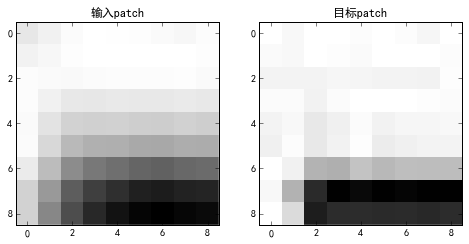

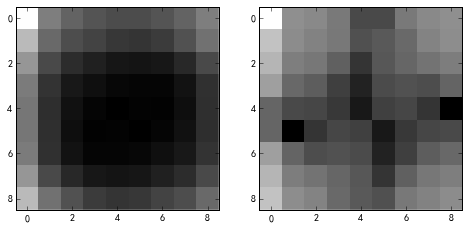

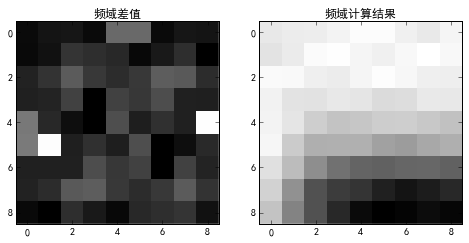

In [29]:
#dp = deformed_patch()

img_in = io.imread("F:\\learning\\pythonGUI-learn\\res\\c1.jpg")
img_out = io.imread("F:\\learning\\pythonGUI-learn\\res\\c2.jpg")

img_in = skimage.color.rgb2gray(img_in)
img_out = skimage.color.rgb2gray(img_out)

#img_in = columnsL[4].reshape((32,32))
#img_out = columnsH[4].reshape((32,32))

in_f = np.log(np.abs(np.fft.fft2(img_in)))
out_f = np.log(np.abs(np.fft.fft2(img_out)))
print out_f.shape

#空域图像
plt.figure(figsize=(8,8),dpi=18)
plt.subplot(1,2,1)
plt.title(u'输入patch')
plt.imshow(img_in,cmap=cm.gray, interpolation="none")

plt.subplot(1,2,2)
plt.title(u'目标patch')
plt.imshow(img_out,cmap=cm.gray, interpolation="none")

#频域图像
plt.figure(figsize=(8,8),dpi=18)
plt.subplot(1,2,1)
plt.imshow(in_f,cmap=cm.gray, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(out_f,cmap=cm.gray, interpolation="none")

#频域计算结果
plt.figure(figsize=(8,8),dpi=18)
plt.subplot(1,2,1)
plt.title(u'频域差值')
plt.imshow(np.abs(in_f-out_f),cmap=cm.gray, interpolation="none")
         
out = np.fft.fft2(img_in)
print out[4,8] #= out[5,7]
print out[5,1] #= out[6,1]
print np.abs(in_f-out_f)[4,8] 
print np.abs(in_f-out_f)[5,1] 
out[5,7]= out[5,7]+3
out[5,7]= out[6,1]+3
c = np.fft.ifft2(out).real
mask = c>255
c[mask] = 255
plt.subplot(1,2,2)
plt.title(u'频域计算结果')
plt.imshow(c ,cmap=cm.gray, interpolation="none")